# Importing relavant modules and packages

In [2]:
from qiskit_aer import AerSimulator
import random
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Operator,Statevector
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import QuantumCircuit,\
    ParameterVector
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize

backend=AerSimulator()

# $M$ and $|b\rangle$

In [4]:
#The matrix we are going to work with
M=np.array([[3,1],[1,-3]])/5
b=np.array([1,1])

b = b/np.linalg.norm(b)
bt=b.T
A=M@(np.eye(2)-np.outer(bt,b))@M

ops_str=SparsePauliOp.from_operator(A).paulis

coeffs=np.real(SparsePauliOp.from_operator(A).coeffs)
SparsePauliOp.from_operator(A)

SparsePauliOp(['I', 'X', 'Z'],
              coeffs=[ 0.2 +0.j,  0.16+0.j, -0.12+0.j])

# The ansatz $V(\theta)$

In [6]:
def ansatz(Parameters):
    qc=QuantumCircuit(n)
    depth=d #circuit depth

    for s in range(0,depth,n):
        theta=Parameters[s:s+n]
        for i in range(n):
            
            qc.ry(theta[i],i)
        
        for i in range(n-1):
            qc.cz(i,i+1)
        
     
    return qc

nb_params=1
n=1
d=1
Parameters=2*np.pi*np.array([random.random() for _ in range(0, nb_params)])

a=ansatz(Parameters).to_gate()
Parameters[0]

4.1168838133674885

# Hadamard tests

In [8]:
def Hadamard_Test_I(Parameters):    
    qc=QuantumCircuit(2,1)
    qc.h(0)
    qc=qc.compose(a,[1])
    qc.h(0)
    qc.measure(0,0)
    return qc

def Hadamard_Test_X(Parameters):    
    qc=QuantumCircuit(2,1)
    qc.h(0)
    qc=qc.compose(a,[1])
    qc.cx(0,1)
    qc.h(0)
    qc.measure(0,0)
    return qc
    
def Hadamard_Test_Y(Parameters):    
    qc=QuantumCircuit(2,1)
    qc.h(0)
    qc=qc.compose(a,[1])
    qc.cy(0,1)
    qc.h(0)
    qc.measure(0,0)
    return qc
    
def Hadamard_Test_Z(Parameters):
    
    qc=QuantumCircuit(2,1)
    qc.h(0)
    qc=qc.compose(a,[1])
    qc.cz(0,1)
    qc.h(0)
    qc.measure(0,0)
    return qc

# Cost function $C(\theta)=\langle \psi(\theta)|A|\psi(\theta)\rangle$

In [10]:
Shots=10000

def cost_function(Parameters):
    
    qc1=Hadamard_Test_I(Parameters)
    qc1.measure(0,0)
    job1=backend.run(transpile(qc1,backend),shots=Shots).result()
    result1=job1.get_counts()
    r1=2*result1['0']/Shots-1

    qc2=Hadamard_Test_X(Parameters)
    qc2.measure(0,0)
    job2=backend.run(transpile(qc2,backend),shots=Shots).result()
    result2=job2.get_counts()
    r2=2*result2['0']/Shots-1

    qc3=Hadamard_Test_Z(Parameters)
    qc3.measure(0,0)
    job3=backend.run(transpile(qc3,backend),shots=Shots).result()
    result3=job3.get_counts()
    r3=2*result3['0']/Shots-1
    
    ex_A=coeffs[0]*r1+coeffs[1]*r2+coeffs[2]*r3

    return ex_A

# Optimization

In [12]:
from qiskit_algorithms.optimizers import SPSA
learning_rate=0.1
def save(nfev, Parameters, cost_function, learning_rate, trust_region):
    
    print(nfev, cost_function)
    global P,PL
    P.append(cost_function)
    PL.append(Parameters)
P=[]
PL=[]

spsa=SPSA(maxiter=100, callback=save)

spsa.minimize(cost_function, x0=Parameters)

3 0.13666400000000006
6 0.13396800000000006
9 0.13422400000000007
12 0.1353840000000001
15 0.13543200000000005
18 0.1364240000000001
21 0.13497600000000007
24 0.13664000000000007
27 0.13252800000000006
30 0.13384000000000007
33 0.1327600000000001
36 0.13607200000000008
39 0.13526400000000008
42 0.13651200000000008
45 0.13468000000000008
48 0.13295200000000007
51 0.13501600000000008
54 0.13563200000000003
57 0.1346640000000001
60 0.13534400000000008
63 0.13590400000000008
66 0.13644000000000006
69 0.13532000000000005
72 0.13521600000000006
75 0.13560800000000006
78 0.13165600000000008
81 0.13561600000000007
84 0.1344160000000001
87 0.13427200000000009
90 0.13470400000000007
93 0.13498400000000008
96 0.1336400000000001
99 0.13438400000000006
102 0.13480800000000004
105 0.13374400000000006
108 0.13717600000000008
111 0.13692000000000007
114 0.13560800000000006
117 0.13418400000000008
120 0.13554400000000005
123 0.13268800000000003
126 0.13521600000000006
129 0.13561600000000007
132 0.1370

# Plots

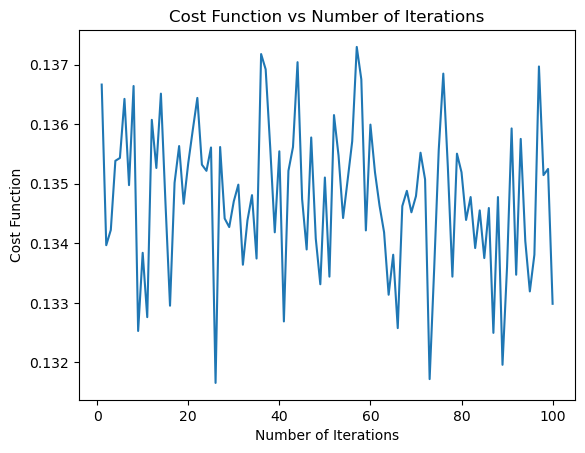

In [14]:
import matplotlib.pyplot as plt

x=np.linspace(1,len(P),len(P))
plt.plot(x, P)

plt.xlabel('Number of Iterations')
plt.ylabel('Cost Function')
plt.title('Cost Function vs Number of Iterations')
plt.show()